# Introduction 
- Trong phần này, ta sẽ quan tâm tới bài toán classification, sử dụng bộ dữ liệu MNIST 
- MNIST là bộ dữ liệu bao gồm 70,000 bức ảnh viết tay (mỗi ảnh bao gồm 784 features) bởi học sinh trung học và người lao động. Mỗi bức ảnh được gán nhãn với một số mà nó biểu diễn. Bài toán MNIST được coi là bài toán mở đầu, hello world trong machine learning 



In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import scipy as sp 


- Sklearn cung cấp sẵn bộ dữ liệu này 

In [3]:
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', version = 1 )
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
print(f"shape of X is {X.shape}")

shape of X is (70000, 784)


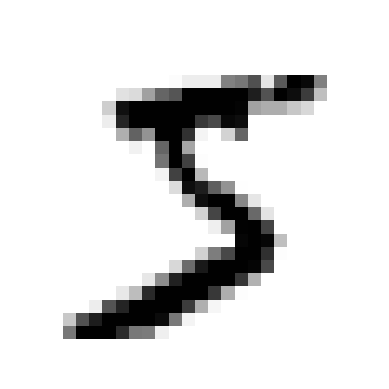

In [5]:
example_img = np.array(X.iloc[0])
example_img_show = example_img.reshape(28, 28)

plt.imshow(example_img_show, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis("off")
plt.show()

In [6]:
y.iloc[0]

'5'

- Tập dữ liệu đã được trộn ngẫu nhiên từ trước, do đó, ta có thể lấy 60000 giá trị đầu tiên làm train set và giá trị còn lại làm test set 


In [7]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Training a Binary Classifier 
- Trong phần này, ta thực hiện train một mô hình binary nhận dạng cho bài toán chữ viết có phải số 5 hay không ? 

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

- Ta lựa chọn một mô hình phân loại và huấn luyện mô hình, ta có thể sử dụng Stochastic Gradient Descent để phục vụ cho bài toán phân loại này

In [9]:
from sklearn.linear_model import SGDClassifier 

sgd_classifier = SGDClassifier(random_state= 42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_classifier.predict([example_img])

d:\WorkSpace_Trung\AI\Hand-on-ML\ml_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures 
- Sau khi train mô hình, ta cần đánh giá được hiệu suất của mô hình, độ chính xác dựa vào một số phép đo 


## Measuring Accuracy using Cross-Validation 
- Để đánh giá độ chính xác của một mô hình, người ta sử dụng cross-validation 

In [11]:
from sklearn.model_selection import cross_val_score 

scores = cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring = "accuracy")
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.87365 0.85835 0.8689 ]


- Có thể thấy, mô hình có accuracy khá cao, tuy nhiên, bộ dữ liệu chỉ có 10% là dữ liệu bằng 5 và phân lớn là khác 5, do đó những dự đoán False toàn bộ cũng có thể có độ chính xác hơn 90% 

In [12]:
len(y[y == '5']) / len(y) 

0.09018571428571429

- Ta sẽ kiểm chứng nhận định trên bằng cách tạo ra mô hình dự đoán giá trị ngẫu nhiên 


In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): 

    def fit(self, X, y=None): 
        pass 

    def predict(self, X): 
        return np.zeros((len(X), 1), dtype=bool) 

In [14]:
never5_clf = Never5Classifier()
never5_score = cross_val_score(never5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")
print("Accuracy: {:.2f}".format(np.mean(never5_score)))

Accuracy: 0.91


=>  Có thể thấy, mô hình chỉ dự đoán giá trị 5 là false có độ chính xác lên tới 91% còn cao hơn cả mô hình dự đoán ta vừa xây dựng
- Từ đó, ta có thể rút ra rằng, accuracy không đánh giá đúng hiệu suất của mô hình

## Confusion Matrix 
- Một cách tối ưu hơn để đánh giá độ chính xác của thuật toán này đó là sử dụng confusion matrix 
- Ý tưởng đắng sau confusion matrix đó là đếm số lần instance thuộc class A được phân loại vào class B 
- Để tính toán confusion matrix, ta tính kết quả dự đoán cross validation 

In [15]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv = 3 )

- Ta sẽ tính confusion matrix dựa vào predict class trên 

In [16]:
from sklearn.metrics import confusion_matrix 

conf_mtx = confusion_matrix(y_train_5, y_train_pred )
conf_mtx

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- Từ kết quả trên, ta có thể đọc, giá trị [0][0] là dự đoán đúng của negative class, giá trị [0][1] là dự đoán sai của class negative, giá trị [1][0] là dự đoán sai của positive class và giá trị [1][1] là dự đoán đúng của positive class 
- Một mô hình chính xác hoàn toàn là khi giá trị dự đoán sai của nó (đường chéo phụ) là bằng 0

- Dựa trên confusion matrix, người ta có thể tính toán một số metrics để đánh giá kết quả của bài toán: 
1. **Precision** : là chỉ số dùng để đánh giá độ chính xác khi dự đoán giá trị positive trong tổng số positive dự đoán. Metrics này được tính như sau: $$ precision = \frac{TP}{TP + FP} $$
2. **Recall**: là chỉ số dùng để đánh giá độ chính xác của dự đoán positive trong tổng số positive thực tế. Metrics này được tính như sau: $$ recall = \frac{TP}{TP + FN} $$

<img src="../Image/fig3-2.png" />

In [17]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
print(f"Precision: {precision}")

recall = recall_score(y_train_5, y_train_pred)
print(f"Recall: {recall}")

Precision: 0.8370879772350012
Recall: 0.6511713705958311


- Tính 2 chỉ số với mô hình trên, có thể thấy chỉ số Precision tương đối cao, trong khi đưa ra dự đoán 5, có 83% dự đoán positive là đúng (100 dự đoán, 83 dự đoán đúng). Trong khi đó, trên tập dữ liệu, có 65% dự đoán được dự đoán là đúng (100 positive - 65 cái được phân loại đúng)
- Đôi khi, trong một số bài toán, việc lựa chọn precision hoặc recall làm chỉ số quan trọng hơn phụ thuộc vào từng bài toán. Với bài toán phân loại video độc hại cho người dùng, chỉ số precision cần phải tương đối cao (dự đoán đưa ra phải đúng cao trong tổng số dự đoán), chỉ số recall có thể thấp (số lượng positive được phân loại có thể thấp). Nói tóm lại, precision được lựa chọn cao hơn nếu việc dự đoán ra những false positive thường mang lại hậu quả lớn (nhầm độc hại thành không độc hại). Ngược lại, việc lựa chọn chỉ số recall cao khi việc nhầm lẫn những nhãn thực hành (False Negative) ảnh hưởng rất lớn (Tỷ lệ phân loại bệnh nhân âm tính giả ảnh hưởng)
- Chỉ số $F_1$ dùng để đánh giá kết hợp giữa recall và precision.  : $$  F_1 = \frac{1}{\frac{1}{recall} + \frac{1}{precision}} $$
- Sử dụng $F_1$ là cách để lựa chọn, đánh giá mô hình cân bằng giữa precision và recall

In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print(f'F1 :{f1}')

F1 :0.7325171197343847


- Việc tăng hay giảm giữa 2 metrics có thể tác động ngược lại với metrics còn lại. 
- Nếu tăng precision thông qua việc dịch chuyển ngưỡng quyết định về phía phải (Precision = 100%), khi đó recall giảm  xuống do một giá trị FN được phân loại 
- Nếu tăng recall thông qua việc dịch chuyển ngưỡng quyết định về phía trái (recall = 100%), precision sẽ giảm do có chứa nhiều nhãn được phân loại FP

<img src="../Image/fig3-3.png" />

- Có thể tùy ý lựa chọn độ chính xác của các chỉ số thông qua việc lựa chọn các threshold, ta sẽ tính các giá trị để đưa ra quyết định như sau: 

In [19]:
# return decision score instead of prediction
y_score = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
                             method="decision_function")
y_score

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

- Vẽ biểu đồ biểu diễn hai metrics giữa các threshold khác nhau: 

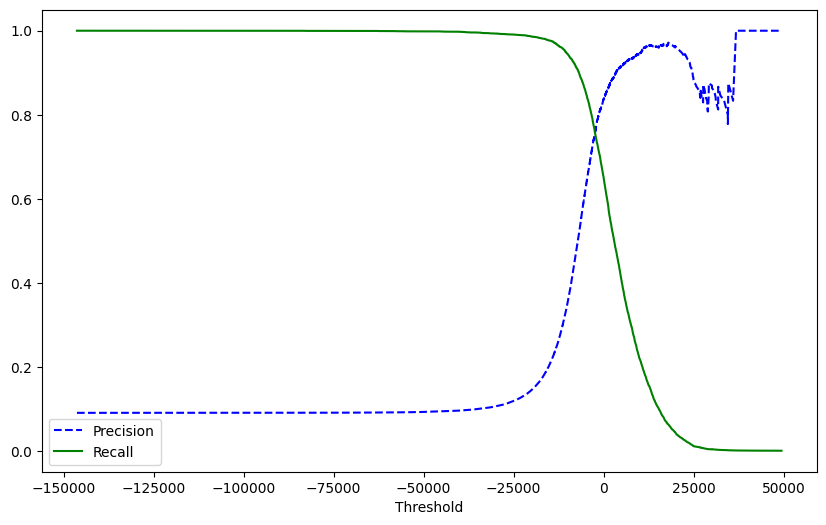

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_score)


def plot_precision_recall_vs_threshold(precision, recall, threshold): 
    plt.subplots(figsize=(10, 6))
    plt.plot(threshold, precision[:-1], "b--", label="Precision")
    plt.plot(threshold, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.show()

plot_precision_recall_vs_threshold(precision, recall, threshold)

## ROC Curve
- Ngoài việc dùng các đường trên, đường ROC cũng được sử dụng, nó được tính thông qua việc vẽ tỉ lệ đúng của positive(recall) và false của positive (tỉ lệ các negative được chia vào trong positive). 
 $$  TPR = \frac {TP}{TP + FN} \\ FPR = \frac{FP}{FP + TN} $$

In [21]:
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)
y_probas = cross_val_predict(forest_classifier, X_train, y_train_5, cv = 3,  method="predict_proba")
y_score_forest = y_probas[:, -1]
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_score_forest)

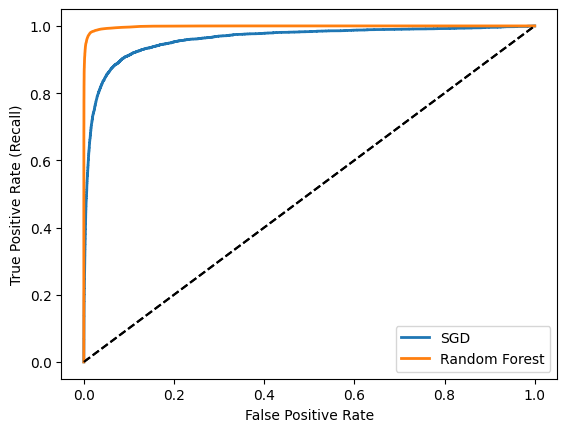

In [22]:


fpr, tpr, threshold = roc_curve(y_train_5, y_score)

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend()
  

plot_roc(fpr, tpr, "SGD")
plot_roc(fpr_forest, tpr_forest, "Random Forest")
plt.show()


- Dựa vào biểu đồ trên, có thể thấy tính đánh đổi giữa các metrics (TPR và FPR) tương tự như với recall và precision
- Người ta có thể trực quan hóa phần diện tích phía dưới của biểu đồ giống như một tham số để đánh giá (AUC), phần diện tích này càng gần 1 thì mô hình được đánh giá càng tốt

- Người ta thường sử dụng các chỉ số Precision, Recall hay biểu đồ PR như trên với trường hợp các positive class rất ít và việc dụ đoán sai positive class có hậu quả lớn (Người bị bệnh ung thư có số lượng positive class nhỏ, nhưng dự đoán sai có hậu quả lớn). Biểu đồ ROC không quan tâm tới số lượng các positive và negative như trên.

## Multiclass Classification 
- Với bài toán phân loại nhiều lớp, một số thuật toán không hỗ trợ cho bài toán này, do đó, có một số hướng tiếp cận cho việc phân loại (N lớp) như sau: 
1. OvA (one versu all): Huấn luyện N mô hình với mỗi mô hình thực hiện bài toán phân loại có hay không thuộc lớp đó. Kết quả đầu ra là lớp có chỉ số cao nhất. Hầu hết trong sklearn, các thuật toán đều được cài đặt dưới dạng OvA
2. OvO (one versu one): Huấn luyện N^2 mô hình với mỗi mô hình thực hiện bài toán phân loại thuộc lớp A hay lớp B. Huấn luyện mô hình này có thể thu nhỏ dataset, tuy nhiên lượng mô hình huấn luyện lớn

In [27]:
sgd_classifier.fit(X_train,  y_train)

SGDClassifier(random_state=42)

In [33]:
test = sgd_classifier.predict([X_test.iloc[4]])
test

d:\WorkSpace_Trung\AI\Hand-on-ML\ml_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array(['4'], dtype='<U1')

In [35]:
y_test.iloc[4]

'4'

In [37]:
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Error Analysis

- Sau khi đánh giá, cần phân tích lỗi của mô hình để điều chỉnh lại mô hình,  đạt được hiệu quả cao hơn

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train.astype(np.float64))

- Confuse Matrix với hàng tương ứng với giá trị trục x (hàng) là giá trị thực tế, trục y(cột) là giá trị dự đoán 

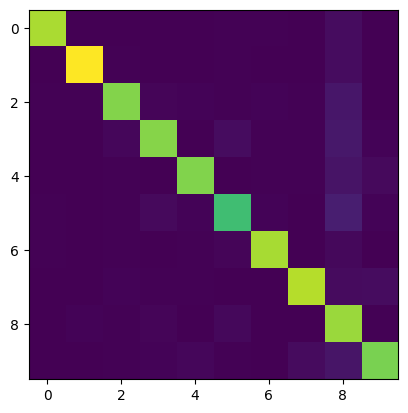

In [40]:
y_train_pred = cross_val_predict(sgd_classifier, X_train_scaler, y_train, cv =3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.imshow(conf_matrix)
plt.show()

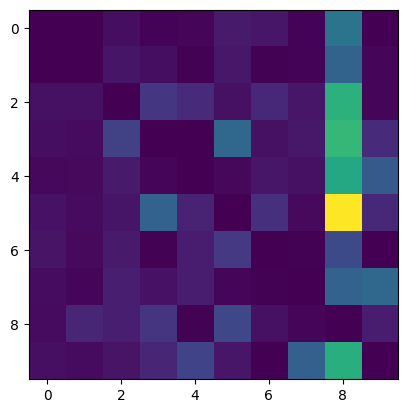

In [41]:
row_sum = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sum
np.fill_diagonal(norm_conf_matrix, 0)
plt.imshow(norm_conf_matrix)
plt.show()

**Phân tích**: Có thể thấy giá trị dự đoán cột 8 thường sáng hơn so với các cột khác, điều này có thể cho thấy các dự đoán tại số 8 thường có kết quả sai khá lớn, đặc biệt bị lầm tưởng sang các số 3, hoặc 5. Cần cải thiện thuật toán hoặc mô hình tại các giá trị này để được dự đoán tốt hơn

# Multilabel Classification 

- Với bài toán phân loại thông thường, việc đưa ra phân loại có thể có nhiều nhãn cho một kết quả. Ví dụ như bài toán Mnist, việc dự đoán không nhất thiết phải là nhãn theo số, có thể có 2 nhãn cho một giá trị dự đoán như Số đó có lớn hơn 7 hay không? và số đó có chia hết cho 2 hay không. Đầu ra sẽ là một vector 2 chiều 

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype(int) >= 7) 
y_train_odd = (y_train.astype(int) % 2 == 1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train_multilabel)

KNeighborsClassifier()

In [55]:
knn_classifier.predict([X_test.iloc[0]])

d:\WorkSpace_Trung\AI\Hand-on-ML\ml_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[ True,  True]])

In [57]:
y_test.iloc[0]

'7'

# Multioutput Classification

- Tương tự như bài toán trên với đầu ra là nhiều nhãn và một đầu vào, ta có thể đưa nhiều đầu vào và nhiều đầu ra cũng lúc cho các bài toán phân loại (multioutput)
- Ví dụ về bài toán multioutput như : Bài toán khử nhiễu của ảnh, với mỗi pixel đại diện cho đầu vào với phân loại xem nó có phải nhiễu hay không ? 

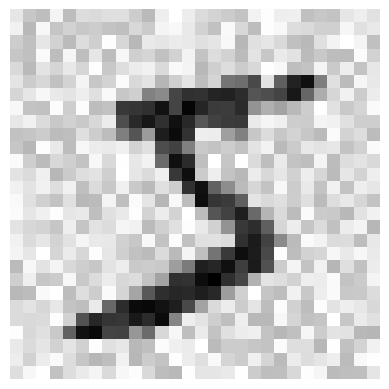

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mo = X_train + noise 
y_train_mo = X_train 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mo = X_test + noise
y_test_no = X_test


plt.imshow(np.array(X_train_mo.iloc[0]).reshape(28,  28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis("off")
plt.show()


d:\WorkSpace_Trung\AI\Hand-on-ML\ml_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


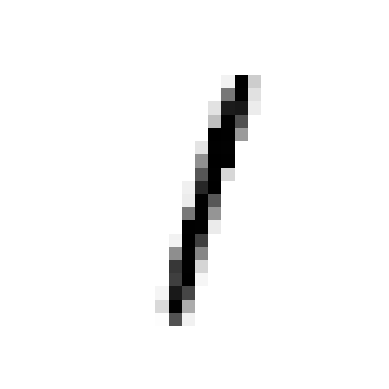

In [67]:
knn_classifier.fit(X_train_mo, y_train_mo)
clean = knn_classifier.predict([X_test.iloc[5]])
plt.imshow(np.array(clean).reshape(28,  28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis("off")
plt.show()


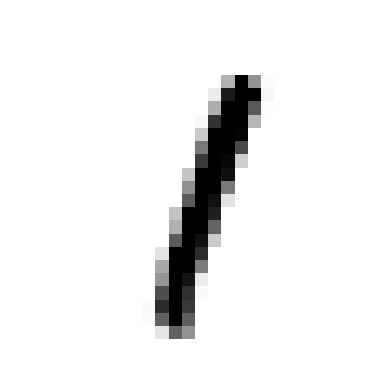

In [68]:
plt.imshow(np.array(y_test_no.iloc[5]).reshape(28,  28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis("off")
plt.show()